imports and data uploads
-----------

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter('ignore')
import os
from scipy import stats
import colorcet as cc
import scipy
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline

In [2]:
# upload data
cpath = os.getcwd() #assumes mean_df_females is in the same path as the notebook
female_mean_df = pd.read_csv(cpath+'/mean_df_female.csv')
female_mean_df = female_mean_df[female_mean_df['rep']!=1] #balance female/male dataset
female_mean_df['rep'] = female_mean_df['rep']-1 # rename repetitions 1-14
male_mean_df = pd.read_csv(cpath+'/mean_df_male.csv')

# ----------------------------------------------------------------------- 
# ANALYSIS
# -----------------------------------------------------------------------

In [3]:
# plot/colors definitions
data_loc=cpath+'/figs/'
try:
    os.mkdir(data_loc)
except FileExistsError:
    # directory already exists
    pass

plt.style.use("seaborn-paper")
cmap2= ['#6C6295','#FBB040']

In [4]:
def KLD_analysis(frequencies):
    '''rows are sessions (or mice/phases), columns are variables (syllables)'''
    cohort_dist=np.zeros((len(frequencies),len(frequencies)),dtype=float)
    x=0
    y=0
    for i in frequencies:
        for j in frequencies:
            i[i==0]=.0000000001
            j[j==0]=.0000000001
            cohort_dist[x,y]=scipy.stats.entropy(pk=np.array(i), qk=np.array(j))
            y=y+1
        y=0
        x=x+1
    return cohort_dist

# split data by n days

In [5]:
ri = 7 # how many days to pool together

## for males

In [6]:
m = male_mean_df.rep.max() # max repetition
ind=1 #counter for bins
mdf = pd.DataFrame()

# for males
for i in list(range(1, m,ri)):
    ## get current data
    df = male_mean_df[(male_mean_df['rep']>=i) & (male_mean_df['rep']<=i+ri-1)]
    
    ## calcualte KLD's
    # KLD between mice (average syllable use per mouse)
    mm=[]
    temp_mean_df= df.groupby(by = ['mouse', 'syllable']).mean()['usage'].reset_index()
    mean_df_lc = pd.pivot_table(temp_mean_df, values='usage', index=['mouse'], columns=['syllable']).reset_index().fillna(0)
    mm=mean_df_lc.drop(['mouse'], axis=1).to_numpy()
    KLD_indv = KLD_analysis(mm)
    mean_kld_indv = np.mean(KLD_indv,axis=0)

    # KLD between repetitions (within mouse)
    temp_mean_df = df.groupby(by = ['mouse', 'rep', 'syllable']).mean()['usage'].reset_index()
    mean_df_lc = pd.pivot_table(temp_mean_df, values='usage', index=['mouse','rep'], columns=['syllable']).reset_index().fillna(0)
    mean_kld_rep=[]
    mice = mean_df_lc['mouse'].unique()
    for choose in mice:
            curr = mean_df_lc[mean_df_lc['mouse'] == choose]
            curr = curr.drop(['mouse','rep'], axis=1).to_numpy()
            KLD_rep = KLD_analysis(curr)
            mean_kld_rep.append(np.mean(KLD_rep))

    # for all sessions
    mean_kld_all=[]
    data_all=mean_df_lc.drop(['mouse','rep'], axis=1).to_numpy()
    kld_all=KLD_analysis(data_all)
    mean_kld_all = np.mean(kld_all,axis=0)
    
    ## create dataframe and save for male
    kld = np.concatenate((np.array(mean_kld_all),
                          np.array(mean_kld_indv),
                          np.array(mean_kld_rep)))
    comp = np.concatenate((len(np.array(mean_kld_all)) * ['all'],
                             len(np.array(mean_kld_indv)) * ['inter-indv'],
                             len(np.array(mean_kld_rep)) * ['intra-indv']))
    time = len(comp) * [str(ind)]
    sex = len(comp) * ['male']
    ind=ind+1
    data = pd.DataFrame({'KLD': list(kld), 
           'exp': list(comp),
           'time':list(time),
            'sex':list(sex)})
    # Create DataFrame
    data = data[(data != 0).all(1)] # remove self distance
    mdf = pd.concat([mdf,data])

In [7]:
## for females

In [8]:
m = female_mean_df.rep.max() # max repetition
ind=1 #counter for bins
fdf = pd.DataFrame()

# for males
for i in list(range(1, m,ri)):
    ## get current data
    df = female_mean_df[(female_mean_df['rep']>=i) & (female_mean_df['rep']<=i+ri-1)]
    
    ## calcualte KLD's
    # KLD between mice (average syllable use per mouse)
    mm=[]
    temp_mean_df= df.groupby(by = ['mouse', 'syllable']).mean()['usage'].reset_index()
    mean_df_lc = pd.pivot_table(temp_mean_df, values='usage', index=['mouse'], columns=['syllable']).reset_index().fillna(0)
    mm=mean_df_lc.drop(['mouse'], axis=1).to_numpy()
    KLD_indv = KLD_analysis(mm)
    mean_kld_indv = np.mean(KLD_indv,axis=0)

    # KLD between repetitions (within mouse)
    temp_mean_df = df.groupby(by = ['mouse', 'rep', 'syllable']).mean()['usage'].reset_index()
    mean_df_lc = pd.pivot_table(temp_mean_df, values='usage', index=['mouse','rep'], columns=['syllable']).reset_index().fillna(0)
    mean_kld_rep=[]
    mice = mean_df_lc['mouse'].unique()
    for choose in mice:
            curr = mean_df_lc[mean_df_lc['mouse'] == choose]
            curr = curr.drop(['mouse','rep'], axis=1).to_numpy()
            KLD_rep = KLD_analysis(curr)
            mean_kld_rep.append(np.mean(KLD_rep))

    # for all sessions
    mean_kld_all=[]
    data_all=mean_df_lc.drop(['mouse','rep'], axis=1).to_numpy()
    kld_all=KLD_analysis(data_all)
    mean_kld_all = np.mean(kld_all,axis=0)
    
    ## create dataframe and save for female
    kld = np.concatenate((np.array(mean_kld_all),
                          np.array(mean_kld_indv),
                          np.array(mean_kld_rep)))
    comp = np.concatenate((len(np.array(mean_kld_all)) * ['all'],
                             len(np.array(mean_kld_indv)) * ['inter-indv'],
                             len(np.array(mean_kld_rep)) * ['intra-indv']))
    time = len(comp) * [str(ind)]
    sex = len(comp) * ['female']
    ind=ind+1
    data = pd.DataFrame({'KLD': list(kld), 
           'exp': list(comp),
           'time':list(time),
            'sex':list(sex)})
    # Create DataFrame
    data = data[(data != 0).all(1)] # remove "0"
    fdf = pd.concat([fdf,data])

Compare male and female KLD
----------

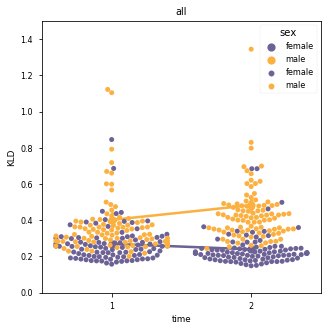

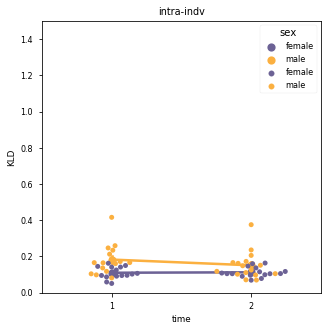

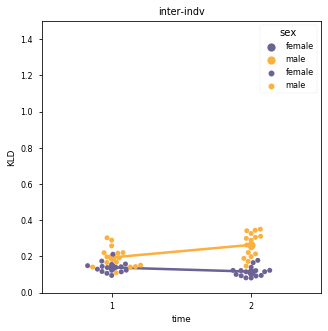

In [9]:
#which data
vars=['all','intra-indv','inter-indv']

for var in vars:
    df = pd.concat([fdf,mdf])
    df = df[df.exp==var]

    #### plot all
    # lineplot
    fig, ax = plt.subplots()
    fig.set_size_inches(5,5)
    ax.set_ylim([0,1.5]) # for "all" change to 1.5, for all else chage to 0.5
    ax = sns.pointplot(x="time",y="KLD",data=df, hue='sex',errorbar='se',estimator='mean',palette = cmap2)
    ax = sns.swarmplot(x="time",y="KLD",data=df, hue='sex',palette = cmap2)
    ax.set_title(var)
    fig.savefig(data_loc +'mf_kld_dynamics'+str(ri)+'days'+var+'.pdf', bbox_inches='tight')

## statistics for time dynamics

In [10]:
#2-way anova
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind

# for each exp explore male/female first/sec
formula = 'KLD ~ C(sex) + C(time) + C(sex):C(time)'
klds = pd.concat([fdf,mdf])

var='all'
df = klds[klds.exp==var]
#perform anova
print ('2-way anova ', var)
model = ols(formula, data=df).fit()
an_table=sm.stats.anova_lm(model, typ=2)
print(an_table)

# performed ttest
print ('ttest')
#which data
ivsp= ttest_ind (df[(df.sex=='male')&(df.time=='1')].KLD, df[(df.sex=='male')&(df.time=='2')].KLD, equal_var=False)
print('male '+var, ivsp.pvalue)
ivsp= ttest_ind (df[(df.sex=='female')&(df.time=='1')].KLD, df[(df.sex=='female')&(df.time=='2')].KLD, equal_var=False)
print('female '+var, ivsp.pvalue)

var='intra-indv'
df = klds[klds.exp==var]
#perform anova
print ('2-way anova ', var)
model = ols(formula, data=df).fit()
an_table=sm.stats.anova_lm(model, typ=2)
print(an_table)

# performed ttest
print ('ttest')
#which data
ivsp= ttest_ind (df[(df.sex=='male')&(df.time=='1')].KLD, df[(df.sex=='male')&(df.time=='2')].KLD, equal_var=False)
print('male '+var, ivsp.pvalue)
ivsp= ttest_ind (df[(df.sex=='female')&(df.time=='1')].KLD, df[(df.sex=='female')&(df.time=='2')].KLD, equal_var=False)
print('female '+var, ivsp.pvalue)

var='inter-indv'
df = klds[klds.exp==var]
#perform anova
print ('2-way anova ', var)
model = ols(formula, data=df).fit()
an_table=sm.stats.anova_lm(model, typ=2)
print(an_table)

# performed ttest
print ('ttest')
#which data
ivsp= ttest_ind(df[(df.sex=='male')&(df.time=='1')].KLD, df[(df.sex=='male')&(df.time=='2')].KLD, equal_var=False)
print('male '+var, ivsp.pvalue)
ivsp= ttest_ind (df[(df.sex=='female')&(df.time=='1')].KLD, df[(df.sex=='female')&(df.time=='2')].KLD, equal_var=False)
print('female '+var, ivsp.pvalue)

2-way anova  all
                   sum_sq     df          F        PR(>F)
C(sex)           3.384278    1.0  46.261314  4.086820e-11
C(time)          0.066140    1.0   0.904104  3.422944e-01
C(sex):C(time)   0.293537    1.0   4.012495  4.588156e-02
Residual        27.506537  376.0        NaN           NaN
ttest
male all 0.12728895765590154
female all 0.03431790951745857
2-way anova  intra-indv
                  sum_sq    df          F    PR(>F)
C(sex)          0.049472   1.0  14.076284  0.000398
C(time)         0.003400   1.0   0.967428  0.329272
C(sex):C(time)  0.004680   1.0   1.331496  0.253115
Residual        0.210874  60.0        NaN       NaN
ttest
male intra-indv 0.26233175467379005
female intra-indv 0.8113137513458216
2-way anova  inter-indv
                  sum_sq    df          F        PR(>F)
C(sex)          0.164450   1.0  73.032263  5.774610e-12
C(time)         0.008667   1.0   3.848897  5.442260e-02
C(sex):C(time)  0.034302   1.0  15.233428  2.431139e-04
Residual        

# CV analysis


## for males

In [11]:
ri = 7 # how many days to pool together
m = male_mean_df.rep.max() # max repetition
ind=1 #counter for bins
mdf = pd.DataFrame()

# for males
for i in list(range(1, m,ri)):
    ## get current data
    df = male_mean_df[(male_mean_df['rep']>=i) & (male_mean_df['rep']<=i+ri-1)]
    
    ##calcualte cv
    # CV between mice (average syllable use per mouse)
    mm=[]
    temp_mean_df= df.groupby(by = ['mouse', 'syllable']).mean()['usage'].reset_index()
    mean_df_lc = pd.pivot_table(temp_mean_df, values='usage', index=['mouse'], columns=['syllable']).reset_index().fillna(0)
    mm=mean_df_lc.drop(['mouse'], axis=1).to_numpy()
    sys=np.nanstd(np.array(mm), axis=0)
    sym=np.nanmean(np.array(mm), axis=0)
    cv_indv=sys/sym # each syllable will have a cv value

    # CV between repetitions (within mouse)
    cv_rep=[]
    temp_mean_df = df.groupby(by = ['mouse', 'rep', 'syllable']).mean()['usage'].reset_index()
    mean_df_lc = pd.pivot_table(temp_mean_df, values='usage', index=['mouse','rep'], columns=['syllable']).reset_index().fillna(0)
    mice = mean_df_lc['mouse'].unique()
    for choose in mice:
        curr = mean_df_lc[mean_df_lc['mouse'] == choose]
        curr = curr.drop(['mouse','rep'], axis=1).to_numpy()
        sys=np.nanstd(np.array(curr), axis=0)
        sym=np.nanmean(np.array(curr), axis=0)
        cv_rep.append(sys/sym)
    mean_cv_rep = np.mean(cv_rep,axis=0)
    
    # for all sessions
    cv_all=[]
    data_all=mean_df_lc.drop(['mouse','rep'], axis=1).to_numpy()
    cv_all=np.nanstd(np.array(data_all), axis=0)/np.nanmean(np.array(data_all), axis=0)

    ## create dataframe and save for male
    cv = np.concatenate((np.array(cv_all),
                          np.array(cv_indv),
                          np.array(mean_cv_rep)))
    comp = np.concatenate((len(np.array(cv_all)) * ['all'],
                             len(np.array(cv_indv)) * ['inter-indv'],
                             len(np.array(mean_cv_rep)) * ['intra-indv']))
    time = len(comp) * [str(ind)]
    sex = len(comp) * ['male']
    ind=ind+1
    data = pd.DataFrame({'cv': list(cv), 
           'exp': list(comp),
           'time':list(time),
            'sex':list(sex)})
    # Create DataFrame
    mdf = pd.concat([mdf,data])

## for females

In [12]:
m = female_mean_df.rep.max() # max repetition
ind=1
fdf = pd.DataFrame()

# for females
for i in list(range(1, m,ri)):
    ## get current data
    df = female_mean_df[(female_mean_df['rep']>=i) & (female_mean_df['rep']<=i+ri-1)]
    
    ##calcualte cv
    # CV between mice (average syllable use per mouse)
    mm=[]
    temp_mean_df= df.groupby(by = ['mouse', 'syllable']).mean()['usage'].reset_index()
    mean_df_lc = pd.pivot_table(temp_mean_df, values='usage', index=['mouse'], columns=['syllable']).reset_index().fillna(0)
    mm=mean_df_lc.drop(['mouse'], axis=1).to_numpy()
    sys=np.nanstd(np.array(mm), axis=0)
    sym=np.nanmean(np.array(mm), axis=0)
    cv_indv=sys/sym # each syllable will have a cv value

    # CV between repetitions (within mouse)
    cv_rep=[]
    temp_mean_df = df.groupby(by = ['mouse', 'rep', 'syllable']).mean()['usage'].reset_index()
    mean_df_lc = pd.pivot_table(temp_mean_df, values='usage', index=['mouse','rep'], columns=['syllable']).reset_index().fillna(0)
    mice = mean_df_lc['mouse'].unique()
    for choose in mice:
        curr = mean_df_lc[mean_df_lc['mouse'] == choose]
        curr = curr.drop(['mouse','rep'], axis=1).to_numpy()
        sys=np.nanstd(np.array(curr), axis=0)
        sym=np.nanmean(np.array(curr), axis=0)
        cv_rep.append(sys/sym)
    mean_cv_rep = np.mean(cv_rep,axis=0)
    
    # for all sessions
    cv_all=[]
    data_all=mean_df_lc.drop(['mouse','rep'], axis=1).to_numpy()
    cv_all=np.nanstd(np.array(data_all), axis=0)/np.nanmean(np.array(data_all), axis=0)

    ## create dataframe and save for female
    cv = np.concatenate((np.array(cv_all),
                          np.array(cv_indv),
                          np.array(mean_cv_rep)))
    comp = np.concatenate((len(np.array(cv_all)) * ['all'],
                             len(np.array(cv_indv)) * ['inter-indv'],
                             len(np.array(mean_cv_rep)) * ['intra-indv']))
    time = len(comp) * [str(ind)]
    sex = len(comp) * ['female']
    ind=ind+1
    data = pd.DataFrame({'cv': list(cv), 
           'exp': list(comp),
           'time':list(time),
            'sex':list(sex)})
    # Create DataFrame
    fdf = pd.concat([fdf,data])

# compare male and female CV

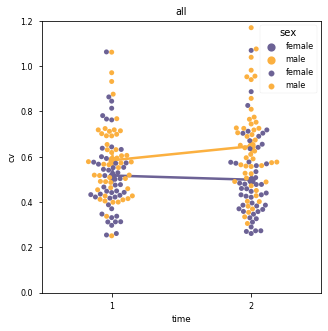

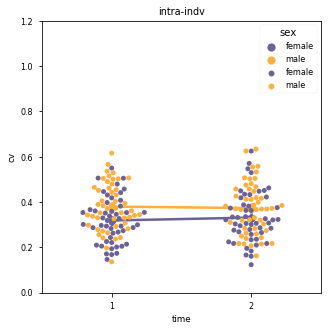

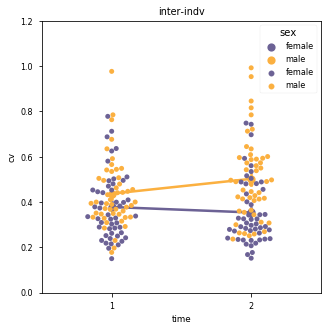

In [13]:
#which data
vars=['all','intra-indv','inter-indv']

for var in vars:
    df = pd.concat([fdf,mdf])
    df = df[df.exp==var]

    #### plot all
    # lineplot
    fig, ax = plt.subplots()
    fig.set_size_inches(5,5)
    ax.set_ylim([0,1.2]) #change to 0.8 for intra-indv
    ax = sns.pointplot(x="time",y="cv",data=df, hue='sex',errorbar='se',estimator='mean',palette = cmap2)
    ax = sns.swarmplot(x="time",y="cv",data=df, hue='sex',palette = cmap2)
    ax.set_title(var)
    fig.savefig(data_loc +'mf_cv_dynamics'+str(ri)+'days'+var+'.pdf', bbox_inches='tight')

## statistics for time dynamics

In [14]:
# for each exp explore male/female first/sec
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind

formula = 'cv ~ C(sex) + C(time) + C(sex):C(time)'
cvs = pd.concat([fdf,mdf])

var='all'
df = cvs[cvs.exp==var]
#perform anova
print ('2-way anova ', var)
model = ols(formula, data=df).fit()
an_table=sm.stats.anova_lm(model, typ=2)
print(an_table)

# performed ttest
print ('ttest')
#which data
ivsp= ttest_ind (df[(df.sex=='male')&(df.time=='1')].cv, df[(df.sex=='male')&(df.time=='2')].cv, equal_var=False)
print('male '+var, ivsp.pvalue)
ivsp= ttest_ind (df[(df.sex=='female')&(df.time=='1')].cv, df[(df.sex=='female')&(df.time=='2')].cv, equal_var=False)
print('female '+var, ivsp.pvalue)

var='intra-indv'
df = cvs[cvs.exp==var]
#perform anova
print ('2-way anova ', var)
model = ols(formula, data=df).fit()
an_table=sm.stats.anova_lm(model, typ=2)
print(an_table)

# performed ttest
print ('ttest')
#which data
ivsp= ttest_ind (df[(df.sex=='male')&(df.time=='1')].cv, df[(df.sex=='male')&(df.time=='2')].cv, equal_var=False)
print('male '+var, ivsp.pvalue)
ivsp= ttest_ind (df[(df.sex=='female')&(df.time=='1')].cv, df[(df.sex=='female')&(df.time=='2')].cv, equal_var=False)
print('female '+var, ivsp.pvalue)

var='inter-indv'
df = cvs[cvs.exp==var]
#perform anova
print ('2-way anova ', var)
model = ols(formula, data=df).fit()
an_table=sm.stats.anova_lm(model, typ=2)
print(an_table)

# performed ttest
print ('ttest')
#which data
ivsp= ttest_ind (df[(df.sex=='male')&(df.time=='1')].cv, df[(df.sex=='male')&(df.time=='2')].cv, equal_var=False)
print('male '+var, ivsp.pvalue)
ivsp= ttest_ind (df[(df.sex=='female')&(df.time=='1')].cv, df[(df.sex=='female')&(df.time=='2')].cv, equal_var=False)
print('female '+var, ivsp.pvalue)

2-way anova  all
                  sum_sq     df          F    PR(>F)
C(sex)          0.566151    1.0  17.800064  0.000038
C(time)         0.023557    1.0   0.740655  0.390525
C(sex):C(time)  0.080456    1.0   2.529575  0.113375
Residual        6.106774  192.0        NaN       NaN
ttest
male all 0.09713283270858492
female all 0.5939156951623508
2-way anova  intra-indv
                  sum_sq     df          F    PR(>F)
C(sex)          0.130844    1.0  11.475375  0.000856
C(time)         0.000435    1.0   0.038184  0.845281
C(sex):C(time)  0.004572    1.0   0.400950  0.527353
Residual        2.189216  192.0        NaN       NaN
ttest
male intra-indv 0.7632400898340115
female intra-indv 0.5491574432252355
2-way anova  inter-indv
                  sum_sq     df          F    PR(>F)
C(sex)          0.526311    1.0  21.630623  0.000006
C(time)         0.020982    1.0   0.862316  0.354257
C(sex):C(time)  0.098417    1.0   4.044780  0.045707
Residual        4.671698  192.0        NaN       N